# Strategy Introduction
This strategy uses Monte Carlo simulation to solve for snowball coupon interest. A snowball option is a structured product, usually linked to the derivatives market, typically with knock-in and knock-out conditions. Its operation is based on whether the underlying asset price reaches a set barrier level within a predetermined period, which determines whether to pay coupon interest, redeem early, or handle it at final maturity. Monte Carlo simulation is a numerical method that uses random sampling and statistical analysis to solve complex problems by approximating the solution through numerous random experiments. In derivative pricing, Monte Carlo simulation includes Brownian motion to generate simulated paths representing asset prices at different points in time. This strategy aims to set parameters such as volatility, knock-out and knock-in prices, and initial prices to simulate different paths of asset prices and returns, settling under specific conditions. This involves the Black-Scholes model, discount calculations, and expectation calculations.

The strategy begins by importing data packages, primarily using PyTorch, and then retrieves trading dates. Next, `def` functions are used to set formulas and parameters to calculate coupon payments, simulated paths, and the final theoretical yield of the coupon. Finally, it calculates the Greek values of the product to display the price sensitivity to different factors.

## Classification of Possible Outcomes for Different Paths
1. The underlying asset price reaches the knock-out price during the observation period  
<br/> In this case, the product is settled directly, returning 100% of the principal and the returns for the holding period (usually in annualized return terms, with the observation period in months or smaller intervals). Investors can reinvest this money into other products but must bear the risk of early settlement.

2. The underlying asset price does not reach the knock-out price during the observation period but is above the initial price at maturity  
<br/> In this case, the product returns 100% of the principal and the yield over the entire holding period (typically annually), offering substantial returns. However, investors may miss other investment opportunities over the extended period.

3. The underlying asset price does not reach either the knock-out or knock-in prices during the observation period but is below the initial price at maturity  
<br/> Generally, in this case, the product has principal protection, returning 100% of the principal (or a proportionate loss in principal if there is no protection) and the yield over the entire holding period. Investors still achieve a decent return, though the time and final return may not be as favorable as scenarios 1 and 2.

4. The underlying asset price reaches the knock-in price during the observation period but ends up within the knock-out and knock-in range, with the final asset price below the initial price  
<br/> A proportionate loss in principal occurs.

5. The underlying asset price reaches the knock-in price during the observation period but ends within the knock-out and knock-in range, with the final asset price above the initial price  
<br/> Returns 100% of the principal plus the asset’s own gains, without coupon interest.

6. The underlying asset price reaches the knock-in price during the observation period and never returns to the knock-in/knock-out range  
<br/> In this case, the product is settled with a proportionate loss in principal, with greater time and return losses than the previous possible outcomes.

7. The underlying asset price reaches the knock-in price during the observation period but subsequently reaches the knock-out price  
<br/> In this case, 100% of the principal is returned, along with the coupon interest for the holding period.


In [1]:
# Using Pytorch for Acceleration
import numpy as np
import pandas as pd
import torch
import pandas_market_calendars as mcal
from typing import Optional

# Set device to GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Trading Date Retrieval and Expected Payoff Calculation Function Setup
This section mainly contains two functions, `get_trade_calendar` and `calc_payoff`, primarily used to filter trading dates and set up the expected payoff calculation.
<br/>
For trading dates, we use the `pandas` and `pandas_market_calendars` packages for data processing and trading date retrieval. First, we retrieve all dates from the Shanghai Stock Exchange (including open and closed dates), then filter out holidays to remove closed dates, ultimately returning trading dates marked as `is_open` in `cal`.
<br/>
For calculating the expected payoff of the coupon rate, we use the `calc_payoff` function, which references the geometric Brownian motion and the BS (Black-Scholes) model's conditions for option pricing, as well as a combination of the discounting formula with the BS model. The specific parameters include:
1. `cal`: DataFrame containing date information.
2. `vd`: Days from the initial date to the valuation date.
3. `S0`: Initial price of the underlying asset.
4. `vd_price`: Price of the underlying asset on the valuation date.
5. `M`: Number of Monte Carlo simulations.
6. `T`: Time step (usually one year).
7. `q`: Assumed continuous dividend rate.
8. `r`: Assumed risk-free interest rate.
9. `sigma`: Assumed volatility of the underlying asset.
10. `k_in_price`: Knock-in price setting.
11. `k_coupon`: Assumed knock-out payoff.
12. `d_coupon`: Assumed payoff for non-knockout at maturity.
13. `Z`: Standard normal distribution random number (generated if not provided).
<br/>
<br/>
# The formula for simulating the price of the underlying asset \( S(t) \) using geometric Brownian motion is:
<br/>
\[
S(t + \Delta t) = S(t) \times \exp\left((r - q - 0.5 \times \sigma^2) \times \Delta t + \sigma \times \sqrt{\Delta t} \times Z\right)
\]


- **S(t)**: Current price of the underlying asset
- **r**: Risk-free rate
- **q**: Continuous dividend yield
- **sigma**: Volatility of the underlying asset
- **Delta t**: Time step
- **Z**: Random variable from the standard normal distribution

<br/>
# Below is the standard form of Brownian motion, where \(\mu\) is the drift rate of the asset, \(\sigma\) is the volatility, and \(dW_t\) is the Brownian motion.
<br/>
<br/>

First, the function uses `torch` to generate a random seed for repeatable results, following a normal distribution, and calculates the time step using `delta_st`. Then, it calculates the asset price for each day using `st`. After calculating asset prices, it marks knock-out dates with `monitor` and uses `torch` to identify knock-in dates, ultimately calculating payoff and loss based on the earliest settlement date (including non-knockout payoff at maturity), resulting in the expected payoff value `V`.

<br/>
# The present value calculation formula for future cash flows is:
\[
PV = CF \times \exp(-r \times T)
\]

- **PV**: Present value
- **CF**: Future cash flow
- **r**: Risk-free rate
- **T**: Years from the current time to the payment date
- **exp(-r * T)** is the discount factor for option pricing


In [2]:
def get_trade_calendar(start_date, end_date) -> pd.DataFrame:
    sse = mcal.get_calendar('SSE')
    cal = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'), columns=['date'])
    holidays = list(sse.holidays().holidays)
    holidays = [day for day in holidays if (day >= start_date) & (day <= end_date)]
    bus_date = pd.bdate_range(start=start_date, end=end_date, freq='B')
    cal['is_open'] = cal['date'].apply(lambda x: False if x in holidays or x not in bus_date else True)
    return cal

def calc_payoff(cal:pd.DataFrame, # Date data
                vd=0,             # Days from initial date to valuation date
                S0=1,             # Initial price of the underlying asset
                vd_price=1,       # Price of the underlying asset on the valuation date
                M=300000,         # Number of Monte Carlo simulations
                T=1,              # Time step
                q=0.065,          # Continuous dividend yield assumption
                r=0.015,          # Risk-free rate assumption
                sigma=0.15,       # Volatility assumption of the underlying asset
                k_in_price=0.85,  # Knock-in price setting
                k_coupon=0.2,     # Knock-out coupon assumption
                d_coupon=0.2,     # Maturity coupon assumption if not knocked out
                Z=None,           # Standard normal distribution
                ) -> float:
    
    torch.manual_seed(38)
    
    dt = T / cal[cal['is_open'] == 1]['date'].count()
    residual_days = cal[vd:]
    trading_days = residual_days[residual_days['is_open'] == 1].index
    N = len(trading_days) - 1
    
    if Z is None:
        Z = torch.randn(N, M, device=device)
    
    delta_st = (r - q - 0.5 * sigma ** 2) * dt + sigma * torch.sqrt(torch.tensor(dt, device=device)) * Z
    delta_st = torch.cat([torch.zeros((1, M), device=device), delta_st], dim=0)
    st = torch.cumprod(torch.exp(delta_st), dim=0) * torch.tensor(vd_price, device=device)
    st_df = pd.DataFrame(st.cpu().numpy(), index=trading_days)
    
    kout_days = residual_days[residual_days['monitor'] == 1].index
    kout_days = [day for day in kout_days if day in st_df.index]  # Check and filter dates
    if not kout_days:
        return 0.0  # Return 0 if there are no knock-out days
    
    kout = np.tile(kout_days, (M, 1)).T
    kout = np.where(st_df.loc[kout_days].gt(cal.loc[kout_days, 'B_out'], axis=0), kout, np.inf)
    kout_date = np.min(kout, axis=0)
    
    kin = torch.any(st < k_in_price, dim=0)
    
    kout_date_tensor = torch.tensor(kout_date, device=device, dtype=torch.float32)
    pnl_kout = torch.sum(kout_date_tensor[kout_date_tensor != np.inf] / 365 * k_coupon * torch.exp(-r * kout_date_tensor[kout_date_tensor != np.inf] / 365))
    pnl_htm = torch.sum(((kout_date_tensor == np.inf) & (kin == False)).float()) * d_coupon * torch.exp(-torch.tensor(r * T, device=device))
    pnl_loss = torch.sum((st[-1, (kout_date_tensor == np.inf) & kin & (st[-1] < S0)] / S0 - 1) * torch.exp(-torch.tensor(r * T, device=device)))
    V = (pnl_htm + pnl_kout + pnl_loss) / M
    
    return V.item()


# Monte Carlo Simulation and Final Theoretical Coupon Calculation
The main purpose of this section is to set up the `simulate` function for Monte Carlo simulation and to set up `calculate_theoretical_coupon` and an embedded function `payoff_with_coupon`, which respectively perform path simulation, final coupon calculation, and calculate the payoff value for all paths with the specified coupon.

In `simulate`:
- `underlying`: Name or code of the underlying asset.
- `initial_price`: Initial price of the underlying asset.
- `start_date`: Contract start date.
- `end_date`: Contract end date.
- `monitor`: List of knockout observation dates.
- `r`: Risk-free rate assumption.
- `capital`: Notional principal.
- `k_coupon`: Knockout yield assumption.
- `k_in_ratio`: Knock-in ratio.
- `k_out_ratios`: List of knockout ratios.
- `k_out_prices`: List of knockout prices (optional).
- `k_in_price`: Knock-in price (optional).
- `d_coupon`: Yield assumption if not knocked out at maturity (optional).
- `vd_price`: Price of the underlying asset on the valuation date (optional).
- `vd_date`: Valuation date (optional).
- `margin_ratio`: Margin ratio.
- `M`: Number of Monte Carlo simulations.
- `unit`: Whether to return unit yield.
- `**kwargs`: Other parameters.

First, the function uses `monitor` to set the end date to -1, then calculates the knock-in price—the initial price multiplied by the knock-in price ratio, actual asset price—the initial price, and maturity price—the assumed knockout price. It then recalculates the step size `T`. Finally, it simulates the coupon based on the valuation date `Vd` and trading calendar.

The `calculate_theoretical_coupon` function uses a parameter dictionary `params` and the target value for bisection search (based on `target_value`) and simulation to obtain the final theoretical coupon value. `payoff_with_coupon` is an embedded function that performs the specific simulation, containing the `simulate` and `calc_payoff` functions.


In [3]:
def simulate(underlying:str,                               # Contract name
             initial_price:float,                          # Initial price of the underlying asset
             start_date:str,                               # Contract start date
             end_date:str,                                 # Contract end date
             monitor:list,                                 # Knock-out observation days
             r:float,                                      # Risk-free rate assumption
             capital:float,                                # Notional principal
             k_coupon:float,                               # Knock-out coupon assumption
             k_in_ratio:float,                             # Knock-in ratio
             k_out_ratios:list,                            # Knock-out ratios
             k_out_prices:Optional[float] = None,          # Knock-out prices
             k_in_price:Optional[float] = None,            # Knock-in price
             d_coupon:Optional[float] = None,              # Maturity coupon assumption if not knocked out
             vd_price:Optional[float] = None,              # Price of the underlying asset on the valuation date
             vd_date:Optional[str] = None,                 # Valuation date
             margin_ratio:float = 1,                       # Margin ratio
             M = 300000,                                   # Number of Monte Carlo simulations
             unit=True,
             **kwargs): 
    
    if monitor[-1] != end_date:
        end_date = monitor[-1]
    
    if k_out_prices is not None:
        assert len(monitor) == len(k_out_prices), 'knock out prices and knock out days are not at same length'
    assert isinstance(k_out_prices, list), 'knock out prices should be list'
    
    if k_in_price is None:
        k_in_price = initial_price * k_in_ratio
    
    if vd_price is None:
        vd_price = initial_price
        
    if d_coupon is None:
        d_coupon = k_coupon
    
    st_dt = pd.to_datetime(start_date)
    ed_dt = pd.to_datetime(end_date)
    T = (ed_dt - st_dt).days / 365
    
    cal = get_trade_calendar(start_date=st_dt, end_date=ed_dt)
    monitor_idx = cal[cal['date'].isin(list(map(pd.to_datetime, monitor)))].index
    cal['monitor'] = np.nan
    cal['B_out'] = np.nan
    cal.loc[monitor_idx, 'monitor'] = 1
    cal.loc[monitor_idx, 'B_out'] = k_out_prices
    
    if vd_date is None:
        vd = 0
    else:
        vd = (pd.to_datetime(vd_date) - st_dt).days
    
    v = calc_payoff(cal=cal, vd=vd, S0=initial_price, vd_price=vd_price, r=r, M=M, T=T, k_in_price=k_in_price, 
                    k_coupon=k_coupon, d_coupon=d_coupon, **kwargs)
    
    if unit:
        return v
    
    return (v + margin_ratio * torch.exp(torch.tensor(r * vd / 365, device=device))) * margin_ratio * capital * torch.exp(torch.tensor(r * vd / 365, device=device))

# Define function to calculate theoretical coupon
def calculate_theoretical_coupon(params, target_value=0):
    def payoff_with_coupon(coupon_rate): # Define internal function to calculate payoff with given coupon
        local_params = params.copy() # Copy parameters
        local_params['k_coupon'] = coupon_rate # Set current coupon rate
        return simulate(**local_params) # Return simulation result
    
    # Binary search to find theoretical coupon
    low, high = 0, 1
    while high - low > 1e-5:
        mid = (low + high) / 2
        if payoff_with_coupon(mid) > target_value:
            high = mid
        else:
            low = mid
    
    return (low + high) / 2 # Return theoretical coupon


# Simulation

In [4]:
# Parameter configuration
params=dict(
    underlying='CSI500 ABRC',                   # Contract name
    initial_price = 5400,                       # Initial price of the underlying asset
    start_date = '20240102',                    # Contract start date
    end_date = '20251231',                      # Contract end date
    vd_date = None,                             # Valuation date
    monitor=['20240430','20240531','20240628',  # Knock-out observation days
             '20240731','20240830','20240930',
             '20241031','20241129','20241231',
             '20250127','20250228','20250331',
             '20250430','20250530','20250630',
             '20250731','20250829','20250930',
             '20251031','20251128','20251231'],
                                  
    k_out_ratios=[1.03] * 21,                   # Knock-out ratios, length must be the same as observation days
    k_out_prices=[5400 * 1.03] * 21,            # Knock-out prices
    k_coupon=0.20,                              # Knock-out coupon assumption
    capital=1,                                  # Notional principal: 1 million
    margin_ratio=1,                             # Margin ratio
    k_in_ratio=0.75,                            # Knock-in ratio
    sigma=0.14,                                 # Volatility assumption of the underlying asset, annualized over the past 3 months
    q=0.063,                                    # Continuous dividend yield assumption
    r=0.015,                                    # Risk-free rate assumption, based on 1-year government bond
)

# Calculate theoretical coupon
theoretical_coupon = calculate_theoretical_coupon(params)
print(f"Theoretical Coupon Rate: {theoretical_coupon}")


Theoretical Coupon Rate: 0.12718582153320312


In [5]:
## BTC Net Value Snowball Parameters

# Parameter Configuration
params = dict(
    underlying='BTC ABRC',                      # Contract Name
    initial_price = 65000,                      # Initial Price of the Underlying Asset
    start_date = '20240102',                    # Contract Start Date
    end_date = '20251231',                      # Contract Maturity Date
    vd_date = None,                             # Valuation Date
    monitor=['20240430','20240531','20240628',  # Knock-out Observation Dates
             '20240731','20240830','20240930',
             '20241031','20241129','20241231',
             '20250127','20250228','20250331',
             '20250430','20250530','20250630',
             '20250731','20250829','20250930',
             '20251031','20251128','20251231'],
                                  
    k_out_ratios=[1.03] * 21,                   # Knock-out Ratios, length must match observation dates
    k_out_prices=[65000 * 1.03] * 21,           # Knock-out Prices
    k_coupon=0.20,                              # Assumed Knock-out Coupon Rate
    capital=1,                                  # Nominal Principal: 1 million
    margin_ratio=1,                             # Margin Ratio
    k_in_ratio=0.75,                            # Knock-in Ratio
    sigma=0.50,                                 # Assumed Volatility of the Underlying, annualized over the past 3 months
    q=0.063,                                    # Assumed Continuous Dividend Yield
    r=0.015,                                    # Assumed Risk-Free Rate, based on 1Y Treasury bond
)

# Calculate Theoretical Coupon
theoretical_coupon = calculate_theoretical_coupon(params)
print(f"Theoretical Coupon Rate: {theoretical_coupon}")


Theoretical Coupon Rate: 0.4711036682128906


In [6]:
# Test 500 Snowball Theoretical Pricing
params = dict(
    underlying='CSI500 ABRC',                   # Contract name
    initial_price = 5400,                       # Initial price of underlying asset
    start_date = '20240102',                    # Contract start date
    end_date = '20251231',                      # Contract expiration date
    vd_date = None,                             # Valuation date
    monitor = ['20240430', '20240531', '20240628',  # Knock-out observation dates
               '20240731', '20240830', '20240930',
               '20241031', '20241129', '20241231',
               '20250127', '20250228', '20250331',
               '20250430', '20250530', '20250630',
               '20250731', '20250829', '20250930',
               '20251031', '20251128', '20251231'],
                                  
    k_out_ratios = [1.03] * 21,                 # Knock-out ratio, length should be the same as observation dates
    k_out_prices = [5400 * 1.03] * 21,          # Knock-out price
    k_coupon = 0.20,                            # Knock-out coupon assumption
    capital = 1,                                # Nominal principal: 1 million yuan
    margin_ratio = 1,                           # Margin ratio
    k_in_ratio = 0.75,                          # Knock-in ratio
    sigma = 0.14,                               # Underlying volatility assumption, annualized for the past 3 months
    q = 0.063,                                  # Continuous dividend yield assumption
    r = 0.015, # Risk-free rate assumption, using 1Y active government bond
)

v = simulate(**params)
v


0.037391528487205505

# Greek Letter Calculations

The Greek letters of options (Greek Letters) are a set of risk indicators that measure the sensitivity of option prices to various factors (such as underlying asset price, volatility, time, interest rates, etc.).


# Delta
Delta (Δ):
<br/>
Meaning: Delta represents the sensitivity of the option price to changes in the underlying asset price. Specifically, it is the rate of change of the option price relative to the underlying asset price.
<br/>
Function: Measures the magnitude of the option price’s increase or decrease with each unit change in the underlying asset price. For call options, the Delta value is usually between 0 and 1; for put options, the Delta value is typically between -1 and 0.
<br/>
Example: If the underlying asset price increases by $1 ($100 to $101), the option price will increase by 6 dollars


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:30<00:00,  2.70s/it]


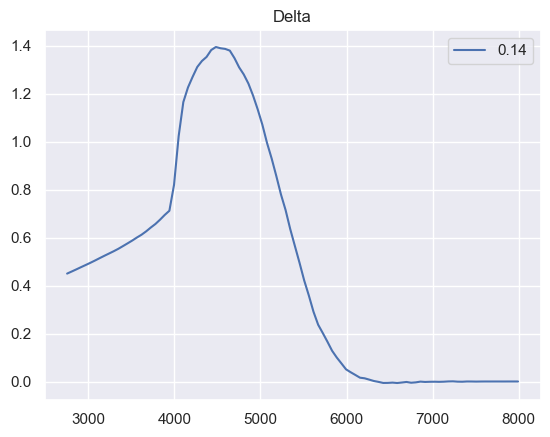

In [7]:
## Solve Dynamic Delta

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
sns.set_theme()

sigma_lst = [0.14]
payoffs, delta, gamma, vega, rho, theta = dict(), dict(), dict(), dict(), dict(), dict()
for sigma in sigma_lst:
    payoffs[sigma], delta[sigma], gamma[sigma], vega[sigma], rho[sigma], theta[sigma] = dict(), dict(), dict(), dict(), dict(), dict()
    for vd_price in tqdm(np.arange(2700, 8100, 54)):
        p = dict(sigma=sigma, vd_price=vd_price)
        params.update(p)
        payoffs[sigma][vd_price] = simulate(**params)

for sigma in sigma_lst:
    for vd_price in np.arange(2754, 8046, 54):
        delta[sigma][vd_price] = (payoffs[sigma][vd_price+54] - payoffs[sigma][vd_price-54]) / (108 / vd_price)
for sigma in sigma_lst:
    plt.plot(list(delta[sigma].keys()), list(delta[sigma].values()))
plt.legend(sigma_lst)
plt.title('Delta')
plt.show()


# Gamma
Gamma (Γ):
<br/>
Meaning: Gamma represents the sensitivity of Delta to changes in the underlying asset's price. It is the rate of change of Delta with respect to the underlying asset's price.
<br/>
Function: Measures the speed of Delta's change. When Gamma is high, Delta is very sensitive to changes in the underlying asset's price.
<br/>
Example: Suppose the option's Gamma is 0.05. If the underlying asset's price rises from 100 to 101, Delta would change from 0.6 to the new Delta = 0.6 + 0.05 = 0.65.


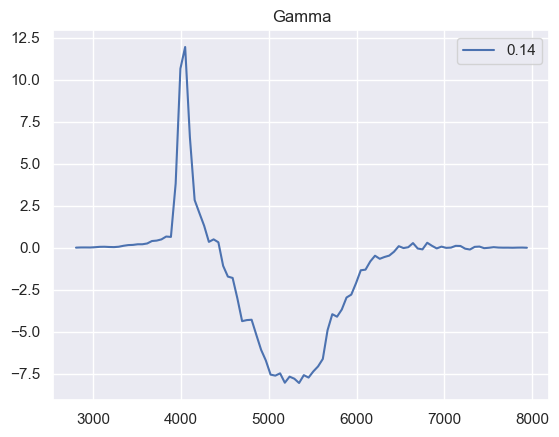

In [8]:
#Gamma
for sigma in sigma_lst:
    for vd_price in np.arange(2808, 7992, 54):
        delta_up = (payoffs[sigma][vd_price+108] - payoffs[sigma][vd_price]) / (108 / vd_price)
        delta_down = (payoffs[sigma][vd_price] - payoffs[sigma][vd_price-108]) / (108 / vd_price)
        gamma[sigma][vd_price] = (delta_up - delta_down) / (108 / vd_price)
for sigma in sigma_lst:
    plt.plot(list(gamma[sigma].keys()), list(gamma[sigma].values()))
    plt.legend(sigma_lst)
    plt.title('Gamma')
    plt.show()

# Vega
Vega (ν)：
<br/>
Meaning: Vega represents the sensitivity of an option's price to changes in the volatility of the underlying asset. It is the rate of change in the option's price relative to changes in volatility.
<br/>
Function: Measures the sensitivity of the option's price to changes in volatility. Generally, the higher the volatility, the higher the option price (especially for out-of-the-money options).
<br/>
Example: Suppose the Vega of a given option is 0.10, and the current volatility of the underlying asset is 20%. If volatility increases by 1 percentage point (from 20% to 21%), the option price is expected to rise by $0.10.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:02<00:00,  5.43s/it]


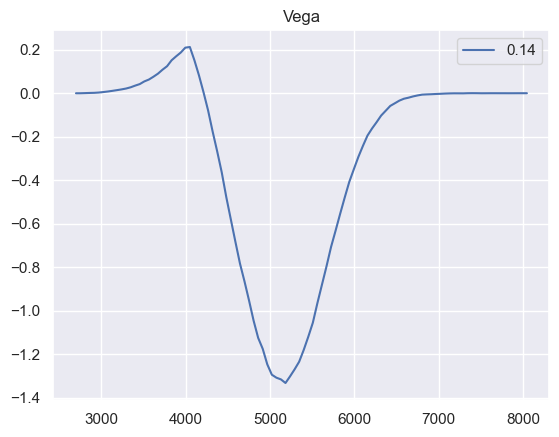

In [9]:
#Vega
for sigma in sigma_lst:
    for vd_price in tqdm(np.arange(2700, 8100, 54)):
        params.update(dict(sigma=sigma + 0.01, vd_price=vd_price))
        payoff_up = simulate(**params)
        params.update(dict(sigma=sigma - 0.01))
        payoff_down = simulate(**params)
        vega[sigma][vd_price] = (payoff_up - payoff_down) / 0.02
for sigma in sigma_lst:    
    plt.plot(list(vega[sigma].keys()), list(vega[sigma].values()))
    plt.legend(sigma_lst)
    plt.title('Vega')
    plt.show()

# Theta
Theta (Θ):
<br/>
Meaning: Theta represents the sensitivity of the option price to the passage of time. It is the rate of change in the option price concerning the reduction of time (usually measured daily).
<br/>
Function: Measures the rate at which the option price decays with the passage of time, often referred to as "time decay." Theta is usually negative, indicating that as the expiration date approaches, the time value of the option gradually decreases.
<br/>
Example: Suppose your option has a Theta of -0.02, meaning each day that passes will cause the option price to decrease by $0.02.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:53<00:00,  5.33s/it]


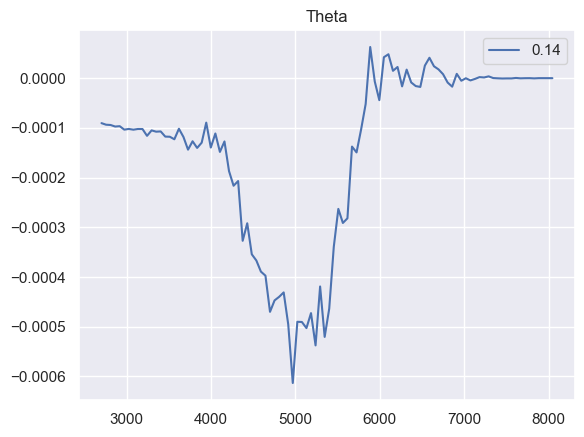

In [10]:
#Theta
for vd_price in tqdm(np.arange(2700, 8100, 54)):
        params_copy = params.copy()
        params_copy.update(dict(vd_price=vd_price, vd_date=(pd.to_datetime(params['start_date']) + pd.Timedelta(days=1)).strftime('%Y%m%d')))
        payoff_up = simulate(**params_copy)
        params_copy.update(dict(vd_date=params['start_date']))  # Reset to original
        payoff_down = simulate(**params_copy)
        theta[sigma][vd_price] = (payoff_down - payoff_up) / 1  # Theta is typically per day
for sigma in sigma_lst:
    plt.plot(list(theta[sigma].keys()), list(theta[sigma].values()))
    plt.title('Theta')
    plt.legend(sigma_lst)
    plt.show()

# Rho
Rho (ρ):
<br/>
Meaning: Rho represents the sensitivity of an option's price to changes in the risk-free interest rate. It is the rate of change in the option's price with respect to changes in the risk-free rate.
<br/>
Function: Measures the sensitivity of the option's price to changes in interest rates. Generally, the Rho of a call option is positive, while the Rho of a put option is negative.
<br/>
Example: Suppose you have a call option with a Rho value of 0.05, and the current risk-free interest rate is 5%. If the interest rate rises by 1 percentage point (from 5% to 6%), the option price is expected to increase by $0.05.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:02<00:00,  5.43s/it]


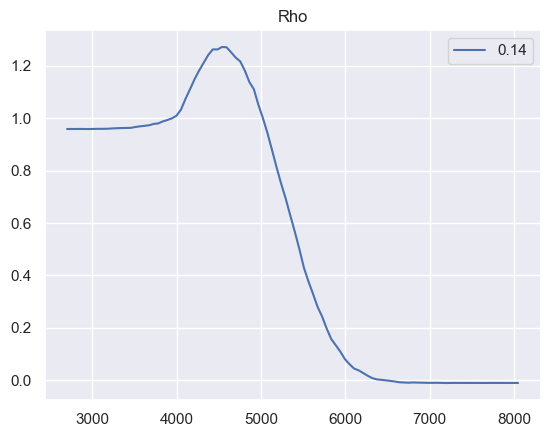

In [11]:
#Rho
for sigma in sigma_lst:
    for vd_price in tqdm(np.arange(2700, 8100, 54)):
        params.update(dict(r=params['r'] + 0.01, vd_price=vd_price))
        payoff_up = simulate(**params)
        params.update(dict(r=params['r'] - 0.01))
        payoff_down = simulate(**params)
        rho[sigma][vd_price] = (payoff_up - payoff_down) / 0.02
for sigma in sigma_lst:  
    plt.plot(list(rho[sigma].keys()), list(rho[sigma].values()))
    plt.title('Rho')
    plt.legend(sigma_lst)
    plt.show()

# Coupon Path Simulation

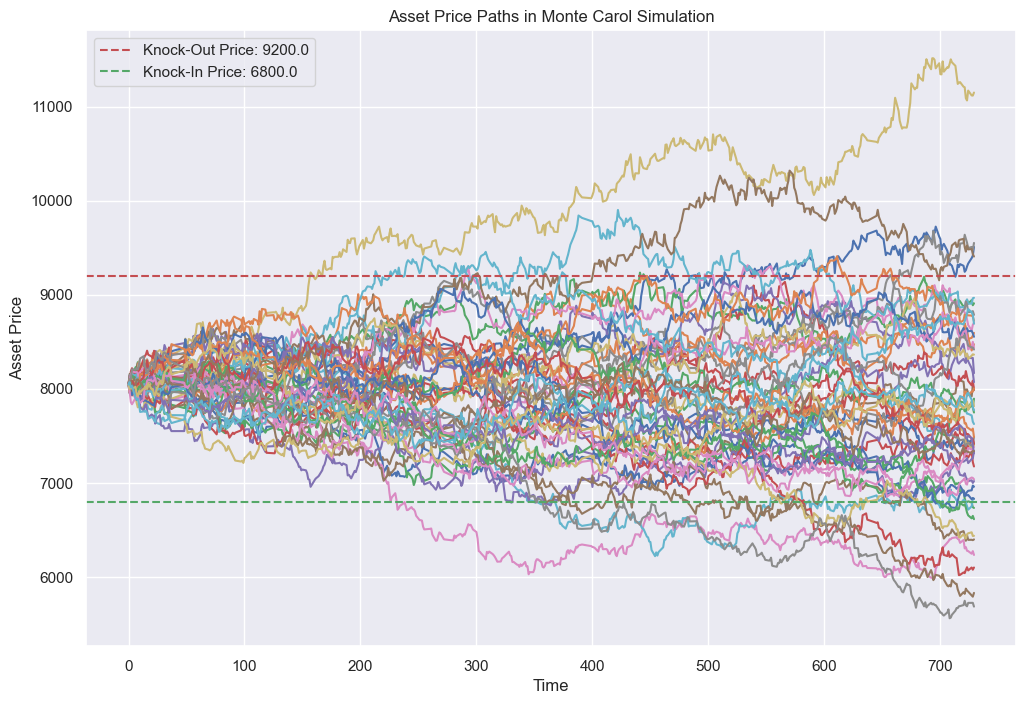

In [21]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calc_payoff_with_paths(cal: pd.DataFrame,
                           vd=0,
                           S0=1,
                           vd_price=1,
                           M=300000,
                           T=1,
                           q=0.065,
                           r=0.015,
                           sigma=0.15,
                           k_in_price=0.85,
                           k_coupon=0.2,
                           d_coupon=0.2,
                           Z=None) -> pd.DataFrame:
    
    torch.manual_seed(38)
    
    dt = T / cal[cal['is_open'] == 1]['date'].count()
    residual_days = cal[vd:]
    trading_days = residual_days[residual_days['is_open'] == 1].index
    N = len(trading_days) - 1
    
    if Z is None:
        Z = torch.randn(N, M)  
    
    delta_st = (r - q - 0.5 * sigma ** 2) * dt + sigma * torch.sqrt(torch.tensor(dt)) * Z
    delta_st = torch.cat([torch.zeros((1, M)), delta_st], dim=0)
    st = torch.cumprod(torch.exp(delta_st), dim=0) * vd_price
    st_df = pd.DataFrame(st.numpy(), index=trading_days)
    
    return st_df

def simulate_and_plot_paths(params, num_paths=50):
    
    st_dt = pd.to_datetime(params['start_date'])
    ed_dt = pd.to_datetime(params['end_date'])
    cal = get_trade_calendar(start_date=st_dt, end_date=ed_dt)
    
    monitor_idx = cal[cal['date'].isin(list(map(pd.to_datetime, params['monitor'])))].index
    cal['monitor'] = np.nan
    cal['B_out'] = np.nan
    cal.loc[monitor_idx, 'monitor'] = 1
    cal.loc[monitor_idx, 'B_out'] = params['k_out_prices']
    
    
    valid_keys = ['vd', 'S0', 'vd_price', 'M', 'T', 'q', 'r', 'sigma', 'k_in_price', 'k_coupon', 'd_coupon', 'Z']
    filtered_params = {k: v for k, v in params.items() if k in valid_keys}
    
    
    filtered_params['M'] = num_paths
    
    
    st_df = calc_payoff_with_paths(cal=cal, **filtered_params)
    
    
    plt.figure(figsize=(12, 8))
    for i in range(num_paths):
        plt.plot(st_df.index, st_df.iloc[:, i])
    
    # 标记敲出价和敲入价
    k_out_price = 8000 * 1.15
    k_in_price = 8000 * 0.85
    
    plt.axhline(y=k_out_price, color='r', linestyle='--', label=f'Knock-Out Price: {k_out_price}')
    plt.axhline(y=k_in_price, color='g', linestyle='--', label=f'Knock-In Price: {k_in_price}')
    
   
    plt.legend()
    
    
    plt.title("Asset Price Paths in Monte Carol Simulation")
    plt.xlabel("Time")
    plt.ylabel("Asset Price")
    plt.show()

simulate_and_plot_paths(params, num_paths=50)
